In [1]:
import importlib
from data_io import formats
from data_io.loader import data_loader
importlib.reload(formats)
importlib.reload(data_loader)

from data_io.loader.data_loader import DataLoader
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from tabulate import tabulate

from sklearn.manifold import TSNE
import plotly.express as px
from collections import defaultdict

## Data Loaders

In [2]:
data_loader = DataLoader()

Accident folder not found: ./data/processed/accidents/
Holidays folder not found: ./data/processed/holidays/


### Yearly plots for all stations

In [3]:
data = {}
year = 2024
for s in data_loader.get_bicyle_stations():
    data[s] = data_loader.get_bicycle_pandas(s, interval=(f'{year}-01-01', f'{year + 1}-01-01'), sample_rate='1d')

In [4]:
fig = go.Figure()
colors = px.colors.qualitative.Alphabet

for i, (station, daily_sum) in enumerate(data.items()):
    color = colors[i % len(colors)]
    weekdays = pd.to_datetime(daily_sum['datetime']).dt.day_name()
    fig.add_trace(go.Scatter(
            x=daily_sum['datetime'],
            y=daily_sum['channels_all'],
            mode='lines',
            line=dict(color=color),
            showlegend=False,
            customdata=list(zip([station]*len(daily_sum), weekdays)),
            hovertemplate='Date: %{x}<br>Weekday: %{customdata[1]}<br>Cyclists: %{y}<br>Station: %{customdata[0]}<extra></extra>'
        ))

fig.update_layout(
        title=f"Daily Amount of Cyclists over all stations - ({year})",
        xaxis_title="Date",
        yaxis_title="Number of Cyclists",
        template="plotly_white"
    )
fig.show()

## Korrelationsanalyse: Wetter vs. Fahrradverkehr

In [7]:
# Daten für 2024 abrufen
year = 2024
start_date = f'{year}-01-01'
end_date = f'{year + 1}-01-01'

# Wetterdaten abrufen
weather_df = data_loader.get_weather_pandas(interval=(start_date, end_date), sample_rate='1d')

# Alle Fahrradstationen aggregieren
all_bikes = []
for station in data_loader.get_bicyle_stations():
    bike_df = data_loader.get_bicycle_pandas(station, interval=(start_date, end_date), sample_rate='1d')
    all_bikes.append(bike_df)

# Gesamte Fahrradzahlen pro Tag
total_bikes_df = pd.concat(all_bikes).groupby('datetime').sum().reset_index()

# Daten zusammenführen
merged_df = pd.merge(weather_df, total_bikes_df, on='datetime', how='inner')

print(f"Datenpunkte: {len(merged_df)}")
print(f"Wettervariablen: {weather_df.columns.tolist()}")
print(f"\nErste Zeilen:")
print(merged_df.head())

Datenpunkte: 366
Wettervariablen: ['datetime', 'temperature_2m', 'relative_humidity_2m', 'precipitation', 'rain', 'snowfall', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m']

Erste Zeilen:
                   datetime  temperature_2m  relative_humidity_2m  \
0 2024-01-01 00:00:00+00:00        6.566667             78.250000   
1 2024-01-02 00:00:00+00:00        8.062500             86.750000   
2 2024-01-03 00:00:00+00:00        9.025000             87.791667   
3 2024-01-04 00:00:00+00:00        7.400000             85.458333   
4 2024-01-05 00:00:00+00:00        6.116667             81.875000   

   precipitation  rain  snowfall  cloud_cover  wind_speed_10m  \
0            5.4   5.4       0.0    91.791667       19.108333   
1           44.1  44.1       0.0    99.291667       23.120833   
2           48.3  48.3       0.0    87.750000       24.237500   
3           33.6  33.6       0.0    85.666667       17.491667   
4            0.3   0.3       0.0    95.500000 

Korrelationen zwischen Wettervariablen und Fahrradzahlen:
temperature_2m                : +0.060
snowfall                      : -0.093
wind_gusts_10m                : -0.098
wind_speed_10m                : -0.102
relative_humidity_2m          : -0.121
cloud_cover                   : -0.136
rain                          : -0.211
precipitation                 : -0.216


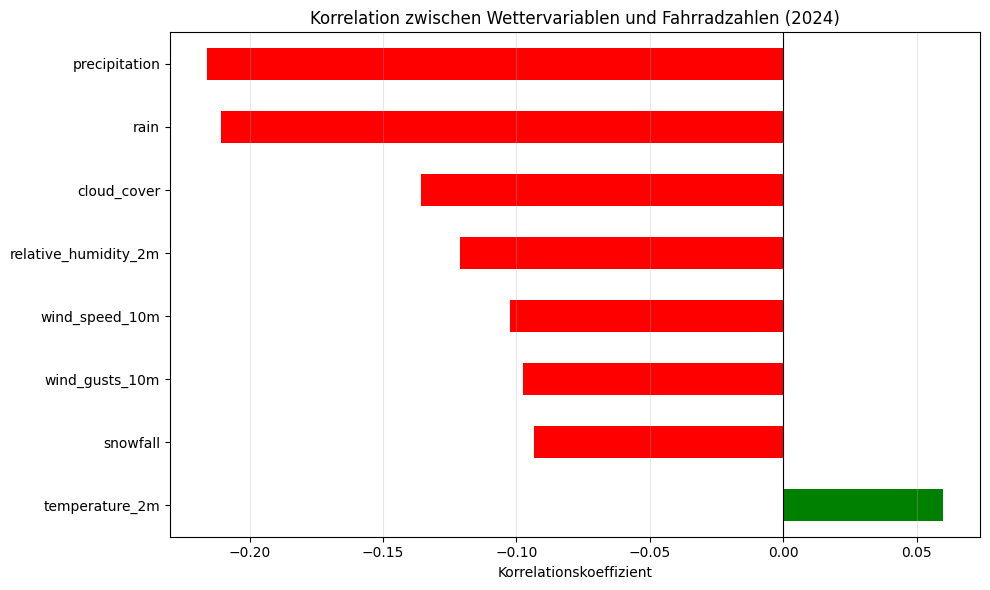

In [6]:
# Korrelationsmatrix berechnen
weather_cols = ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'rain', 
                'snowfall', 'cloud_cover', 'wind_speed_10m', 'wind_gusts_10m']
bike_col = 'channels_all'

# Nur relevante Spalten auswählen
corr_df = merged_df[weather_cols + [bike_col]].copy()

# Korrelationen berechnen
correlations = corr_df.corr()[bike_col].drop(bike_col).sort_values(ascending=False)

print("Korrelationen zwischen Wettervariablen und Fahrradzahlen:")
print("="*60)
for var, corr in correlations.items():
    print(f"{var:30s}: {corr:+.3f}")
    
# Visualisierung
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in correlations.values]
correlations.plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Korrelationskoeffizient')
ax.set_title('Korrelation zwischen Wettervariablen und Fahrradzahlen (2024)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Zeitzonenüberprüfung

In [8]:
# Zeitzonenüberprüfung der Daten
print("="*70)
print("ZEITZONENÜBERPRÜFUNG")
print("="*70)

# Wetterdaten prüfen
print("\n1. WETTERDATEN:")
print(f"   Zeitzone: {weather_df['datetime'].dtype}")
print(f"   Erste datetime: {weather_df['datetime'].iloc[0]}")
print(f"   Letzte datetime: {weather_df['datetime'].iloc[-1]}")

# Fahrraddaten prüfen
print("\n2. FAHRRADDATEN (total_bikes_df):")
print(f"   Zeitzone: {total_bikes_df['datetime'].dtype}")
print(f"   Erste datetime: {total_bikes_df['datetime'].iloc[0]}")
print(f"   Letzte datetime: {total_bikes_df['datetime'].iloc[-1]}")

# Merged Daten prüfen
print("\n3. ZUSAMMENGEFÜHRTE DATEN:")
print(f"   Zeitzone: {merged_df['datetime'].dtype}")
print(f"   Anzahl übereinstimmender Datenpunkte: {len(merged_df)}")
print(f"   Erwartete Tage in 2024: 366 (Schaltjahr)")

# Einzelne Station als Beispiel prüfen
station_name = data_loader.get_bicyle_stations()[0]
single_station_df = data_loader.get_bicycle_pandas(station_name, interval=(start_date, end_date), sample_rate='1h')
print(f"\n4. EINZELSTATION '{station_name}' (stündlich):")
print(f"   Zeitzone: {single_station_df['datetime'].dtype}")
print(f"   Erste datetime: {single_station_df['datetime'].iloc[0]}")
print(f"   Anzahl Stunden: {len(single_station_df)}")
print(f"   Erwartete Stunden: {366 * 24} (366 Tage × 24 Stunden)")

# Prüfen, ob UTC korrekt ist
print("\n5. ZEITZONENVALIDIERUNG:")
import pytz
expected_tz = pytz.UTC
if hasattr(weather_df['datetime'].iloc[0], 'tzinfo'):
    if weather_df['datetime'].iloc[0].tzinfo == expected_tz:
        print("   ✓ Wetterdaten verwenden UTC")
    else:
        print(f"   ⚠ Wetterdaten verwenden: {weather_df['datetime'].iloc[0].tzinfo}")
else:
    print("   ⚠ Wetterdaten haben keine Zeitzone!")
    
if hasattr(total_bikes_df['datetime'].iloc[0], 'tzinfo'):
    if total_bikes_df['datetime'].iloc[0].tzinfo == expected_tz:
        print("   ✓ Fahrraddaten verwenden UTC")
    else:
        print(f"   ⚠ Fahrraddaten verwenden: {total_bikes_df['datetime'].iloc[0].tzinfo}")
else:
    print("   ⚠ Fahrraddaten haben keine Zeitzone!")

print("\n" + "="*70)

ZEITZONENÜBERPRÜFUNG

1. WETTERDATEN:
   Zeitzone: datetime64[us, UTC]
   Erste datetime: 2024-01-01 00:00:00+00:00
   Letzte datetime: 2024-12-31 00:00:00+00:00

2. FAHRRADDATEN (total_bikes_df):
   Zeitzone: datetime64[us, UTC]
   Erste datetime: 2024-01-01 00:00:00+00:00
   Letzte datetime: 2024-12-31 00:00:00+00:00

3. ZUSAMMENGEFÜHRTE DATEN:
   Zeitzone: datetime64[us, UTC]
   Anzahl übereinstimmender Datenpunkte: 366
   Erwartete Tage in 2024: 366 (Schaltjahr)

4. EINZELSTATION 'Plöck' (stündlich):
   Zeitzone: datetime64[us, UTC]
   Erste datetime: 2024-01-01 00:00:00+00:00
   Anzahl Stunden: 8783
   Erwartete Stunden: 8784 (366 Tage × 24 Stunden)

5. ZEITZONENVALIDIERUNG:
   ✓ Wetterdaten verwenden UTC
   ✓ Fahrraddaten verwenden UTC



In [9]:
# Detaillierte Überprüfung: Warum fehlt 1 Stunde?
print("Detailanalyse der fehlenden Stunde:")
print("="*70)

# Alle Stunden generieren für 2024
from datetime import datetime, timedelta
import pandas as pd

start = pd.Timestamp('2024-01-01 00:00:00', tz='UTC')
end = pd.Timestamp('2025-01-01 00:00:00', tz='UTC')
all_hours = pd.date_range(start=start, end=end, freq='h', inclusive='left')

print(f"Erwartete Stunden insgesamt: {len(all_hours)}")
print(f"Tatsächliche Stunden in Daten: {len(single_station_df)}")
print(f"Differenz: {len(all_hours) - len(single_station_df)} Stunde(n)")

# Finde fehlende Stunden
existing_hours = set(single_station_df['datetime'])
missing_hours = [h for h in all_hours if h not in existing_hours]

if missing_hours:
    print(f"\n⚠ Fehlende Stunden ({len(missing_hours)}):")
    for missing in missing_hours[:10]:  # Zeige maximal 10
        print(f"   - {missing}")
        # Prüfe, was an diesem Tag besonders war
        if 'März' in missing.strftime('%B') or 'Oktober' in missing.strftime('%B'):
            print(f"     Hinweis: {missing.strftime('%B')} → Mögliche Zeitumstellung!")
else:
    print("\n✓ Keine fehlenden Stunden gefunden")

# Überprüfe Sommerzeit-Umstellung (letzter Sonntag im März und Oktober)
print("\n" + "="*70)
print("HINWEIS ZUR ZEITUMSTELLUNG:")
print("Europa/Berlin hat Sommerzeit (CEST) und Winterzeit (CET).")
print("Die Daten sind in UTC gespeichert, was korrekt ist!")
print("UTC hat KEINE Zeitumstellung - das ist richtig so.")
print("="*70)

Detailanalyse der fehlenden Stunde:
Erwartete Stunden insgesamt: 8784
Tatsächliche Stunden in Daten: 8783
Differenz: 1 Stunde(n)

⚠ Fehlende Stunden (1):
   - 2024-10-27 01:00:00+00:00

HINWEIS ZUR ZEITUMSTELLUNG:
Europa/Berlin hat Sommerzeit (CEST) und Winterzeit (CET).
Die Daten sind in UTC gespeichert, was korrekt ist!
UTC hat KEINE Zeitumstellung - das ist richtig so.
